# Data Analysis

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
df = pd.read_csv("employee_promotion_updated.csv")

# Clean the data
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Create a mapping dictionary for categorical variables
valueKeyMapping = dict()
for column in df.columns:
    if df[column].dtype == np.dtype("object"):
        unique_values = df[column].unique()
        valueKeyMapping[column] = unique_values

        # Replace categorical values with numerical values using a more efficient approach
        # to avoid the FutureWarning
        mapping = {unique_values[i]: i for i in range(len(unique_values))}
        df[column] = df[column].map(mapping)

    # Display descriptive statistics
print("Dataset Description:")
display(df.describe())

# Display correlation matrix
print("\nCorrelation Matrix:")
display(df.corr(numeric_only=True))

Dataset Description:


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
count,47380.000000,47380.000000,47380.000000,47380.000000,47380.000000,47380.000000,47380.000000,47380.000000,47380.000000,47380.000000,47380.000000,47380.000000,47380.000000
mean,39488.617349,2.269101,10.014795,0.745378,0.693162,0.639215,1.322119,35.660827,3.315832,6.371971,0.064816,64.148443,0.096771
std,22815.154033,2.280083,8.597079,0.581743,0.461187,0.656705,0.864386,7.657385,1.267892,4.265078,0.379122,13.526381,0.295649
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,0.000000,39.000000,0.000000
25%,19793.250000,0.000000,4.000000,0.000000,0.000000,0.000000,1.000000,30.000000,3.000000,3.000000,0.000000,52.000000,0.000000
50%,39425.500000,2.000000,6.000000,1.000000,1.000000,1.000000,1.000000,34.000000,3.000000,5.000000,0.000000,60.000000,0.000000
75%,59126.000000,4.000000,17.000000,1.000000,1.000000,1.000000,1.000000,40.000000,4.000000,8.000000,0.000000,77.000000,0.000000
max,99853.000000,8.000000,33.000000,4.000000,1.000000,5.000000,10.000000,60.000000,5.000000,37.000000,4.000000,99.840000,1.000000



Correlation Matrix:


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
employee_id,1.000000,0.010728,0.011462,0.041493,-0.010581,0.034242,0.038990,0.007321,-0.002702,0.009426,0.070263,0.011291,0.019596
department,0.010728,1.000000,-0.100444,0.003539,-0.076510,0.012320,0.004680,-0.051017,0.059460,-0.042391,0.010538,0.323687,0.000757
region,0.011462,-0.100444,1.000000,0.103300,0.034927,0.027515,0.008388,-0.144422,-0.047940,-0.082862,0.084213,-0.035798,-0.010528
education,0.041493,0.003539,0.103300,1.000000,-0.012170,0.216487,0.285422,-0.244242,-0.049883,-0.127221,0.370825,0.041020,0.082766
gender,-0.010581,-0.076510,0.034927,-0.012170,1.000000,-0.024886,0.023824,-0.009944,-0.016923,-0.017568,-0.050784,-0.023837,-0.024326
recruitment_channel,0.034242,0.012320,0.027515,0.216487,-0.024886,1.000000,0.236714,0.025533,-0.021850,0.038254,0.316460,0.061463,0.092968
no_of_trainings,0.038990,0.004680,0.008388,0.285422,0.023824,0.236714,1.000000,-0.013073,-0.089520,0.017536,0.391704,0.087007,0.091517
age,0.007321,-0.051017,-0.144422,-0.244242,-0.009944,0.025533,-0.013073,1.000000,-0.002624,0.595560,0.052911,-0.054809,-0.008725
previous_year_rating,-0.002702,0.059460,-0.047940,-0.049883,-0.016923,-0.021850,-0.089520,-0.002624,1.000000,-0.011488,-0.054755,0.057119,0.130873
length_of_service,0.009426,-0.042391,-0.082862,-0.127221,-0.017568,0.038254,0.017536,0.595560,-0.011488,1.000000,0.055157,-0.035107,0.007658


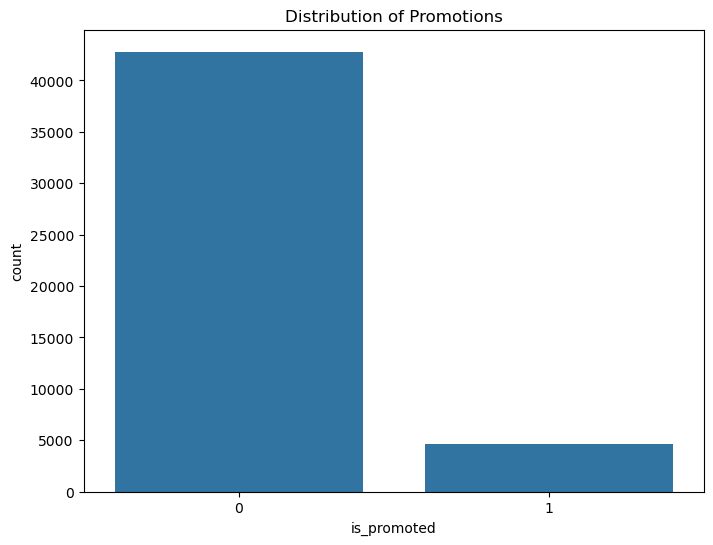

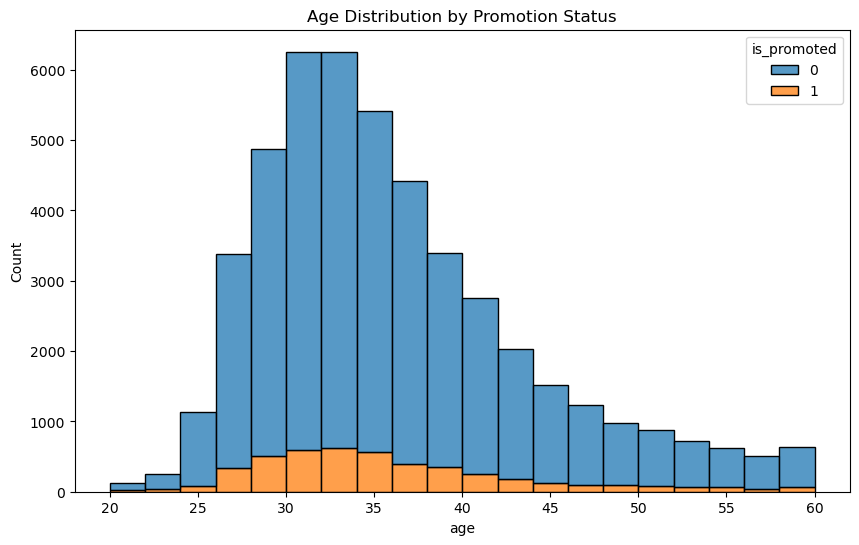

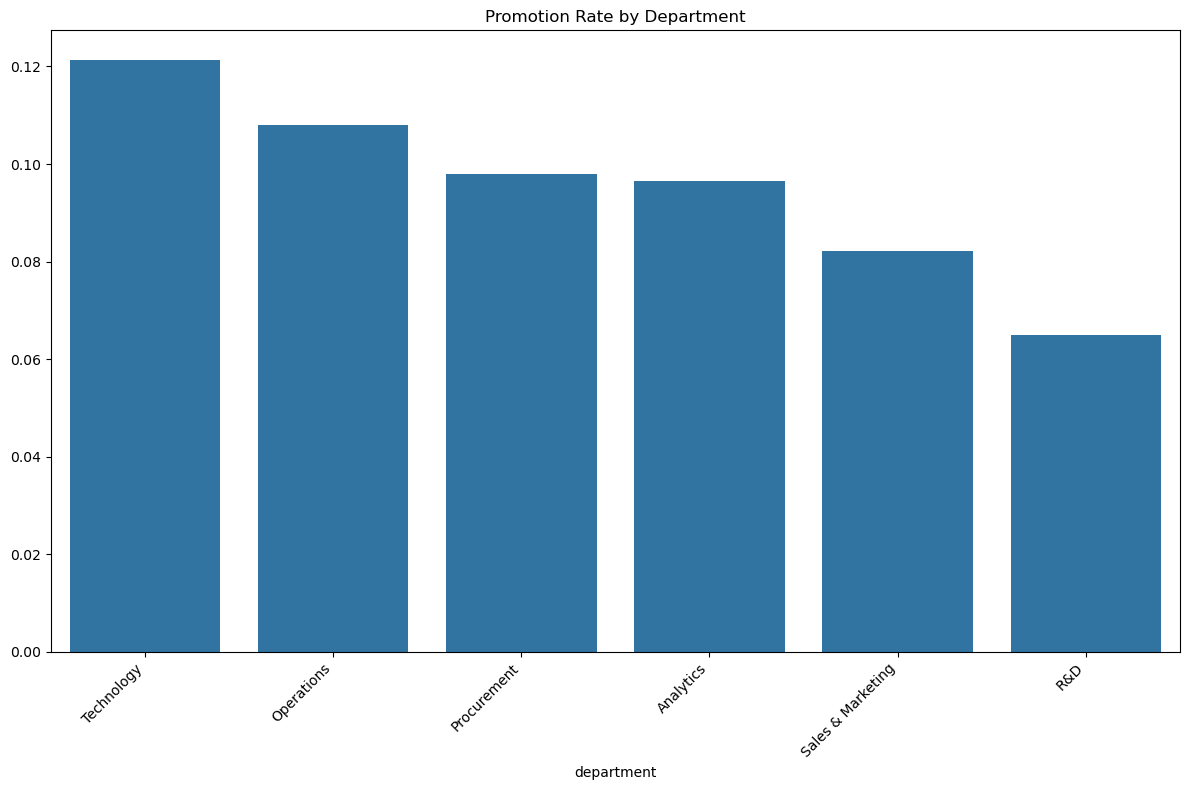

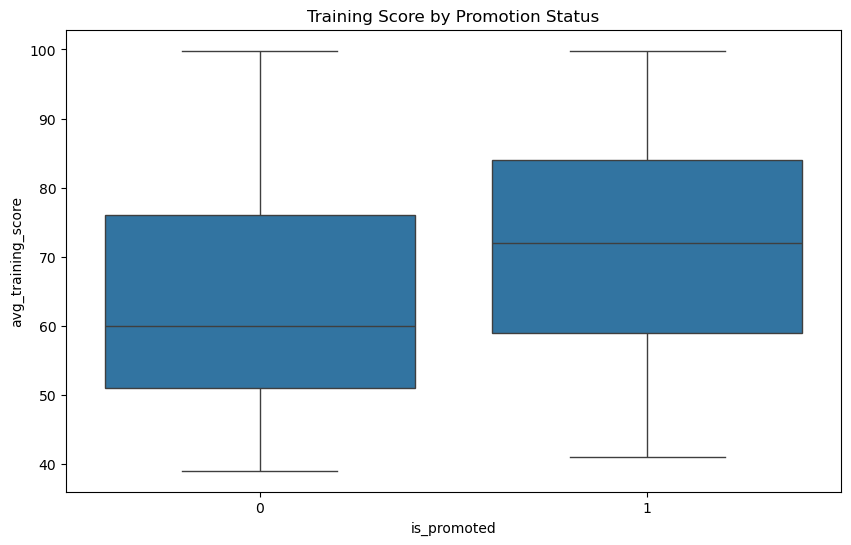

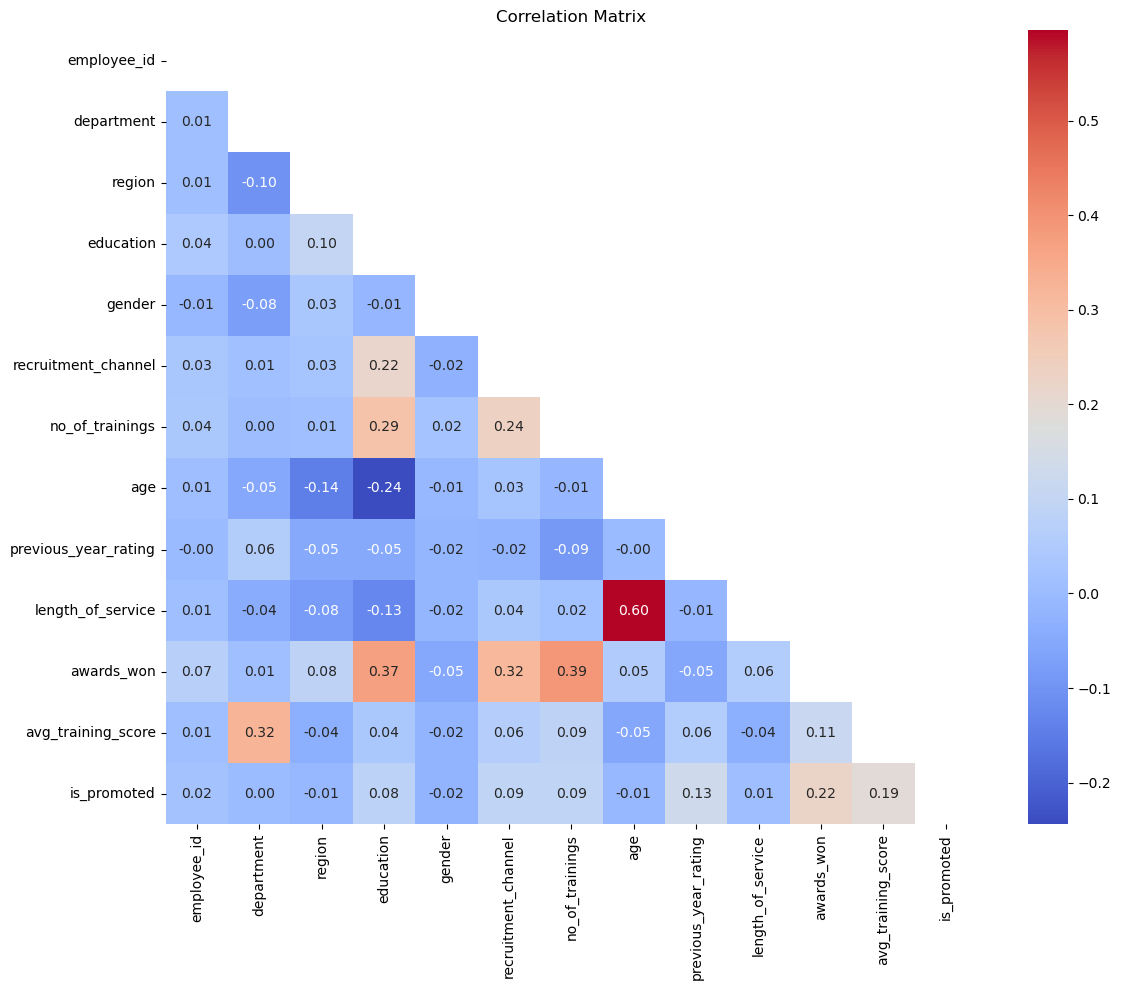

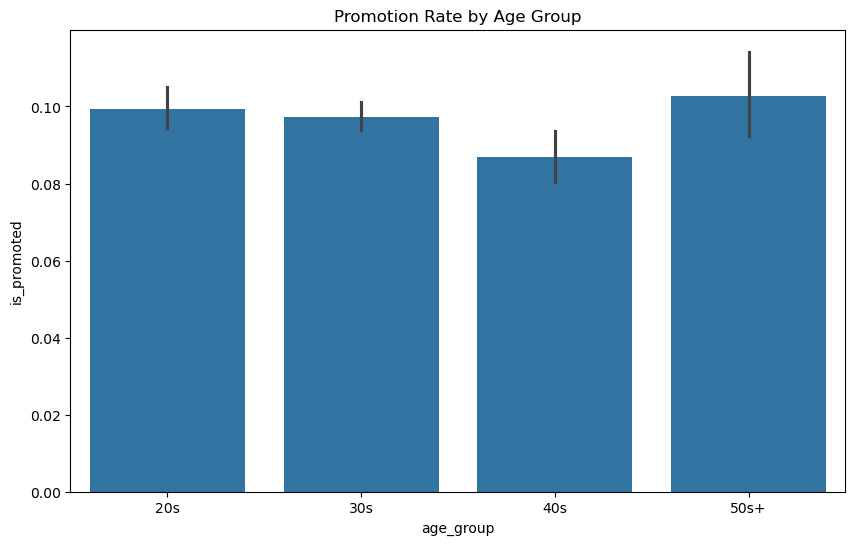

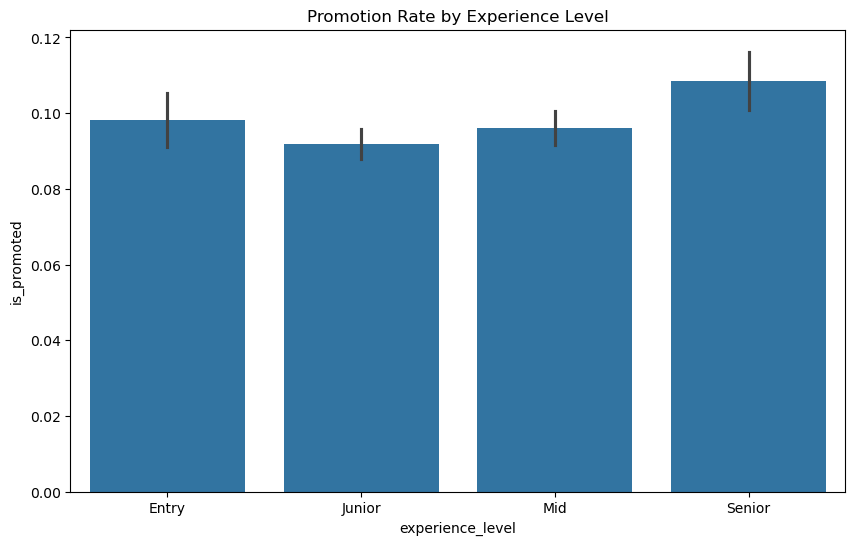

In [32]:
## Explanatory Data Analysis
# Distribution of target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='is_promoted', data=df)
plt.title('Distribution of Promotions')
plt.show()

# Age distribution by promotion status
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='is_promoted', multiple='stack', bins=20)
plt.title('Age Distribution by Promotion Status')
plt.show()

# Promotion rate by department
modified_df = df.copy()
mapping = {i: valueKeyMapping["department"][i] for i in range(len(unique_values))}
modified_df['department'] = modified_df['department'].map(mapping)
plt.figure(figsize=(12, 8))
dept_promotion = modified_df.groupby('department')['is_promoted'].mean().sort_values(ascending=False)
sns.barplot(x=dept_promotion.index, y=dept_promotion.values)
plt.title('Promotion Rate by Department')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Boxplot of training scores by promotion status
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_promoted', y='avg_training_score', data=df)
plt.title('Training Score by Promotion Status')
plt.show()

# Heatmap of correlation matrix
plt.figure(figsize=(12, 10))
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', mask=mask)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Create age groups
df['age_group'] = pd.cut(df['age'], bins=[20, 30, 40, 50, 60], labels=['20s', '30s', '40s', '50s+'])

# Create experience level categories
df['experience_level'] = pd.cut(df['length_of_service'], bins=[0, 2, 5, 10, 30], 
                               labels=['Entry', 'Junior', 'Mid', 'Senior'])

# Create interaction features that might be important
df['rating_x_training'] = df['previous_year_rating'] * df['avg_training_score']

# Analyze promotion rates by age group and experience level
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='is_promoted', data=df)
plt.title('Promotion Rate by Age Group')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='experience_level', y='is_promoted', data=df)
plt.title('Promotion Rate by Experience Level')
plt.show()